<a id="index"></a>
# A modular processing pipeline for spike sorting `Intan` data

In this notebook we will walk through a spike sorting processing pipeline with [SpikeInterface](https://github.com/SpikeInterface) for Intan data. There is another notebook called `axona_spike_sorting_pipeline.ipynb` for working with Axona data.

We will show how to

1. [Install `hussaini_lab_to_nwb`](#install_dependencies)
2. [load data with spikeextractors](#load_data)
3. [Preprocess the signals](#preprocess)
4. [Cache data](#cache)
5. [Spike sort](#spike_sorting)   
   * [Klusta](#klusta)
   * [mountainsort4](#mountainsort4)
   * [Ironclust](#ironclust)
   * [spyking circus](#spykingcircus)
   * [tridesclous](#tridesclous)
   
   
6. [Postprocess the signals](#postprocessing)
7. [Curate the spike sorting output](#spike_curation) with 
        1) quality metrics (automatic), 
        2) [Phy](https://github.com/cortex-lab/phy) (manual), and 
        3) consensus-based curation
8. [Export results to NWB](#export_nwb)
9. [Export results to TINT](#export_tint)


<a id='install_dependencies'></a>
# Install `hussaini_lab_to_nwb`
[back to index](#index)

You can install the package and its dependencies with `pip install hussaini_lab_to_nwb`. The dependencies are listed in `requirements.txt`. We recommend installing it in a clean virtual environment (e.g. with `conda` or `venv`). 

Note that some spike sorters require matlab or additional dependencies, which need to be installed separately. For an overview of possible spike sorters and their dependencies see https://spikeinterface.readthedocs.io/en/latest/sortersinfo.html.

Import packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# General data handling and visualization
import sys
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# SpikeInterface family
import spikeextractors as se
import spikewidgets as sw
import spiketoolkit as st
import spikesorters as ss
import spikecomparison as sc

print(sys.version, sys.platform, sys.executable)

3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0] linux /home/sbuergers/spikeinterface/hussaini_test_pipeline/venv/bin/python


In [3]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (16, 6)
plt.rcParams.update({'font.size':14})

/home/sbuergers/spikeinterface/hussaini_test_pipeline/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<a id='load_data'></a>
# 2. Load data
[back to index](#index)

In [49]:
dir_name = r'/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/Intan_data'
base_filename = 'intan_rhd_test_1.rhd'
filename = os.path.join(dir_name, base_filename)
print(filename)

/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/Intan_data/intan_rhd_test_1.rhd


A `RecordingExtractor` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted). Below we illustrate a few useful methods that describe this particular recording.

In [75]:
recording = se.IntanRecordingExtractor(file_path=filename, verbose=True)

/home/sbuergers/spikeinterface/hussaini_test_pipeline/venv/lib/python3.8/site-packages/pyintan/core.py:143: UserWarning: Could not parse date from intan_rhd_test_1.rhd
  warnings.warn(f"Could not parse date from {fname}")


Found  206  recording channels
Found  0  analog in channels
Found  0  analog out channels
Found  0  stimulation channels
Found  0  digital in channels
Found  0  digital in channels


In [102]:
print('Type of recorindextractor:', type(recording))
print('Channel ids: {}'.format(recording.get_channel_ids()))
print('Num. channels = {}'.format(len(recording.get_channel_ids())))
print('Sampling frequency = {} Hz'.format(recording.get_sampling_frequency()))
print('Num. samples = {}'.format(recording.get_num_frames()))
print('Stdev. on third channel = {}'.format(np.std(recording.get_traces(
    start_frame=0, end_frame=48000, channel_ids=2))))

Type of recorindextractor: <class 'spikeextractors.extractors.intanrecordingextractor.intanrecordingextractor.IntanRecordingExtractor'>
Channel ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191]


/home/sbuergers/spikeinterface/hussaini_test_pipeline/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853:

The `spikewidgets` module includes several convenient plotting functions that can be used to explore the data, for instance by visualizing snippets of data in the time domain:

In [103]:
channel_subset = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

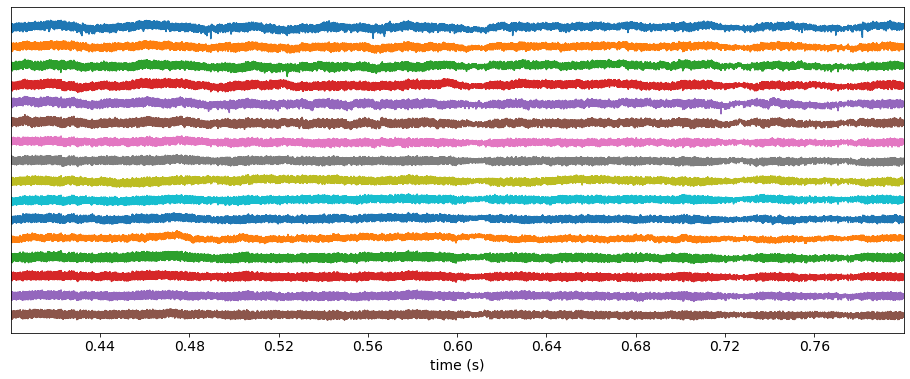

In [104]:
w_ts = sw.plot_timeseries(recording, trange=[0.4, 0.8], channel_ids=channel_subset)

Or in the frequency domain:

/home/sbuergers/spikeinterface/hussaini_test_pipeline/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853:

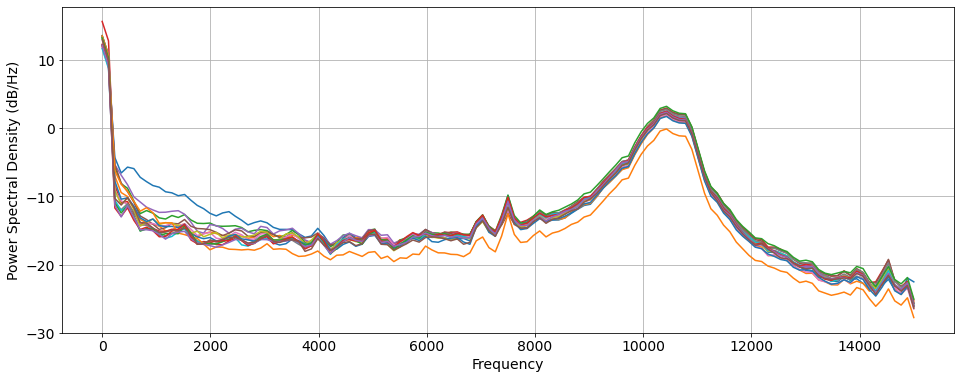

In [105]:
w_sp = sw.plot_spectrum(recording, trange=[0, 1], channels=channel_subset)

It often makes sense to group electrodes together, for instance if they belong to the same tetrode. This can be accomplished with the `set_channel_groups()` method. Correspondingly, we can view the `group` property using the `get_channel_groups` method. 

An alternative way to obtain channel groups is by loading a so called `.prb` file containing channel grouping and physical channel locations. We do not need it here, but it is well explained in this [spikeinterface tutorial](https://github.com/SpikeInterface/spiketutorials/blob/master/NWB_Developer_Breakout_Session_Sep2020/SpikeInterface_Tutorial.ipynb).

For this Intan dataset, we are not aware of channel groupings and the default is to include all channels in the same group in this case. However, this could be problematic for spike sorting later on, since we would not expect all channels to be able to pick up on activity from the same neuron. Instead, we will assign a different group for each channel. Of course, it would be ideal if we knew more about this recording and how the channels should be sensibly grouped.

In [106]:
print(f'Channel groups:\n{recording.get_channel_groups()}')

Channel groups:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


/home/sbuergers/spikeinterface/hussaini_test_pipeline/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [107]:
recording.set_channel_groups([i for i in range(0, len(recording.get_channel_ids()))])

print(f'Channel groups:\n{recording.get_channel_groups()}')

Channel groups:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191]


Some spike sorters (e.g. ironclust) require channel locations. So we will create a fake geometry keeping electrodes on single tetrodes close together. One could use a `.prb` file to accomplish this, but we will simply assign locations with the `set_channel_locations()` method. If the actual geometry is known, you can of course use that instead. 

In [108]:
recording.set_channel_locations(locations=[[0, 10*ch_id] for ch_id in recording.get_channel_ids()],
                                channel_ids=recording.get_channel_ids())

We now have the additional channel property `location`.

In [109]:
print('Channel ids:', recording.get_channel_ids())
print('Loaded properties', recording.get_shared_channel_property_names())

# 'group' and 'location' can be returned as lists:
print('Channel groups:', recording.get_channel_groups())
print('Channel locations:\n', recording.get_channel_locations())

Channel ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191]
Loaded properties ['gain', 'group', 'location', 'offset']
Channel groups: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  

And we can visualize the electrode locations with spikewidgets:

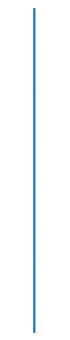

In [110]:
fh = plt.figure(figsize=(1,6))
w_elec = sw.plot_electrode_geometry(recording, figure=fh)

### Properties (and features)

For now we have seen that the `RecordingExtractor` can have `group` and `location` *properies*. These are very special properties that can be very important for spike sorting. But anything related to a channel can be saved as a property.

Similarly, for `SortingExtractor` objects, anything related to a unit can be stored as a property. In addition, for `SortingExtractor` objects we can also store anything related to spikes as *features* (e.g. waveforms, as we'll see later).

We can check which properties are in the extractor as follows:

In [111]:
print('Shared channel property names')
print(recording.get_shared_channel_property_names())

Shared channel property names
['gain', 'group', 'location', 'offset']


<a id='preprocess'></a>
# 3. Preprocessing
[back to index](#index)

Next, we will perform a few preprocessing steps using `spiketoolkit`.

We can filter the recordings, rereference the signals to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, and more (see [here](https://spiketoolkit.readthedocs.io/en/latest/preprocessing_example.html)).

For this notebook, we will filter the recording and apply common median reference (CMR). All preprocessing modules return new `RecordingExtractor` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data.

### Bandpass filter

/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, 

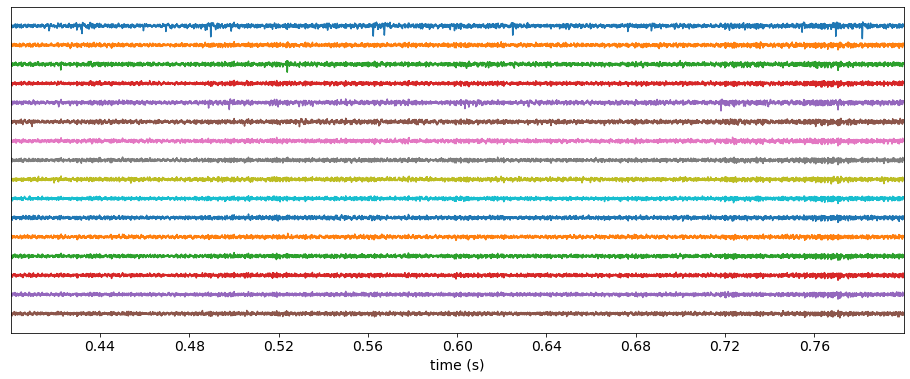

In [112]:
r_filt = st.preprocessing.bandpass_filter(recording, freq_min=300, freq_max=6000)

w = sw.plot_timeseries(r_filt, trange=[0.4, 0.8], channel_ids=channel_subset)

### Common median reference (CMR)

It is often desirable to use a common median reference to remove noise common to all channels.

/home/sbuergers/spikeinterface/hussaini_test_pipeline/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853:

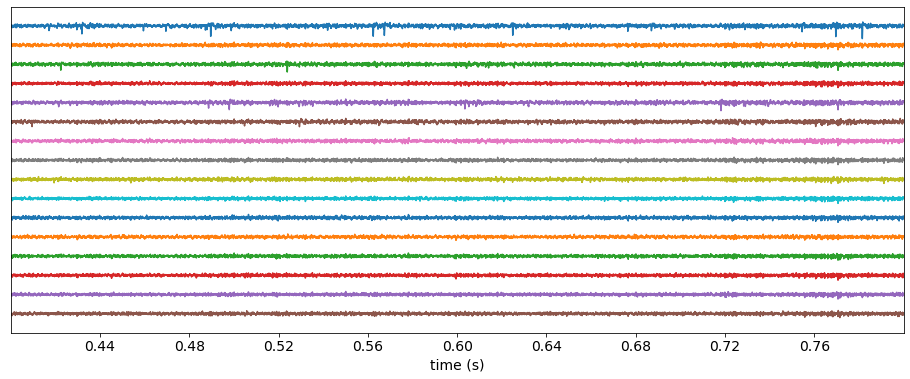

In [113]:
r_cmr = st.preprocessing.common_reference(r_filt, reference='median')
w = sw.plot_timeseries(r_cmr, trange=[0.4, 0.8], channel_ids=channel_subset)

### Selecting subsets of data

We can also select subsets of data in the time domain with `SubRecordingExtractor`. For the example recording we are using here this is not necessary since it is only 1s long, but we still include it here for illustration purposes.

In [114]:
fs = r_cmr.get_sampling_frequency()
r_sub = se.SubRecordingExtractor(r_cmr, start_frame=0*fs, end_frame=1*fs)

/home/sbuergers/spikeinterface/hussaini_test_pipeline/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853:

<a id='cache'></a>
# 4. Cache data
[back to index](#index)

All operations in SpikeInterface are *lazy*, meaning that they are not performed if not needed. This is why the creation of our filter recording was almost instantaneous. However, to speed up further processing, we might want to perform those operations (eg. filters, CMR, etc.) once and **cache** the processed data to a file. This is particularly important if we are going to extract waveforms, templates, pca scores, or in general *post-process* the results.

Note that if the parameter `save_path` is not specified, the cache file will be saved in a temporary folder that will be deleted when the Python session is closed (or the object destroyed). One can get around this by moving the temporary file with `recording_cache.move_to()`, or simply specifying the `save_path` paramter when creating the cache. You can view the directory of the temporary folder with `recording_cache.get_tmp_folder()`.

In [115]:
perma_cache_filename = os.path.join(dir_name, 'cached_data_preproc.dat') 
r_cache = se.CacheRecordingExtractor(r_sub, save_path=perma_cache_filename)
print('Temporary folder:\n{}'.format(r_cache.get_tmp_folder()))

Temporary folder:
/tmp/tmpbo5wds53


Under the hood, this convenient function is retrieving all the traces (in chunks, to save up some memory), applying the preprocessing steps, and dumping them to a binary temporary file:

In [116]:
print(f'Filename: {r_cache.filename}')

Filename: /mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/Intan_data/cached_data_preproc.dat


The cached recording has all the previously loaded information:

In [117]:
print(f'Cached channels: {r_cache.get_channel_ids()}')
print(f'Cached channels ids: {r_cache.get_channel_ids()}')
print(f'Channel groups after caching: {r_cache.get_channel_groups()}')
print('Duration of recording in seconds: {}'.format(r_cache.get_num_frames() / r_cache.get_sampling_frequency()))

Cached channels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191]
Cached channels ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 

If we now closed the Python session, we would have a nice `.dat` file, but no information on how to open it! 
In order to save the state of an extractor, we can use the **dumping** mechanism.
Each extractor can be converted to a dictionary, which holds the path to the data file and all relevant information:

In [118]:
r_cache.dump_to_dict()

{'class': 'spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor',
 'module': 'spikeextractors',
 'kwargs': {'file_path': '/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/Intan_data/cached_data_preproc.dat',
  'sampling_frequency': 30000.0,
  'numchan': 192,
  'dtype': 'float32',
  'recording_channels': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88,
   89,
   90,
   91,
   92,

We can now dump our extractor object, so it can be loaded in a future session. We can dump either to `.json` or to `.pkl`. Dumping to pickle also allows us to store properties (other than group and locations) and features (for `SortingExtractor` objects).

In [119]:
r_cache.dump_to_pickle(os.path.join(dir_name, 'cached_data_preproc.pkl'))

In another session, we can pick up from where we left by loading the extractor from the pickle file:

In [120]:
r_cache = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_data_preproc.pkl'))

In [121]:
print(f'Cached channels ids: {r_cache.get_channel_ids()}')
print(f'Channel groups after caching: {r_cache.get_channel_groups()}')
print('Duration of recording in seconds: {}'.format(r_cache.get_num_frames() / r_cache.get_sampling_frequency()))

Cached channels ids: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191]
Channel groups after caching: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23 

__Note__: the same caching/dumping mechanisms are available also for all `SortingExtractor` objects.

<a id='spike_sorting'></a>
# 5. Spike sorting
[back to index](#index)

We will now run spike sorting on the above recording (`r_cache`). We will show code for `klusta`, `ironclust`, `mountainsort4`, `spykingcircus` and `trideclous` for this demonstration, but there are many other spike sorting algorithms available, all of which can be accessed with the same `spikeinterface` API.

First, we need to install the spike sorters we want. There is a complete overview of spike sorters supported by spikeinterface [here](https://spikeinterface.readthedocs.io/en/latest/sortersinfo.html), including installation instructions. Note that not all spikesorters work on every setup. Some require Matlab. Some require CUDA. 

We can list all installed spike sorting algorithms with the following convenience function.

In [17]:
ss.installed_sorters()

['mountainsort4', 'spykingcircus']

Please, note that we do not take advantage of the parallelizability of the spike sorters in this notebook, because even though we specify `parallel=True`, the number of performed parallel jobs is only one (`n_jobs=1`). We did this to keep the system requirements at a minimum, but we recommend to increase this number depending on your system's capabilities to speed up spike sorting.

<a id='klusta'></a>
### Klusta
[back to index](#index)

Install `Klusta` with pip.

In [ ]:
!pip install Cython h5py tqdm
!pip install click klusta klustakwik2

Finally, we should downgrade h5py to version 2.10.0 to be as compatible as possible with spikesorters

In [ ]:
!pip install h5py==2.10.0

We can retrieve the parameters associated with any sorter with the `get_default_params()` function from the `spikesorters` module, as well as corresponding parameter descriptions using `get_params_description()`.

In [ ]:
ss.get_default_params('klusta')

In [ ]:
ss.get_params_description('klusta')

In [ ]:
ss.run_sorter?

In [ ]:
ss.run_klusta?

Since we have tetrodes and we know that they are physically apart, we would like to sort them separately as follows, assigning the `group` property to the `grouping_property` parameter:

In [ ]:
sorting_KL = ss.run_klusta(
    r_cache,
    adjacency_radius=5,
    output_folder=os.path.join(dir_name, 'klusta'),
    parallel=True,
    n_jobs=1
)
print(f'Klusta found {len(sorting_KL.get_unit_ids())} units')

Below you can see that when the `grouping_property` is used a `MultiSortingExtractor` object is returned, containing several `SortingExtractor` objects, which were created separately for each group. 

In [ ]:
print(type(sorting_KL))
print(type(sorting_KL.sortings[0]))

In [ ]:
print(f'Klusta unit ids: {sorting_KL.get_unit_ids()}')

In [ ]:
print(f'Spike train of a unit: {sorting_KL.get_unit_spike_train(1)}')

We can also visually inspect the data using raster plots.

In [ ]:
w_rs = sw.plot_rasters(sorting_KL, trange=[0.4, 0.8])

We can plot the temporal data for comparison, though it can be quite difficult to visually make out spiking events in noisy data. We will see more rigorous ways for assessing spike sorting outputs later on.

In [ ]:
w = sw.plot_timeseries(r_cache, trange=[0.4, 0.8], channel_ids=channel_subset)

### Loading spike sorting output from a spike sorting folder

If a spike sorter has been run, you can reload the output as a `SortingExtractor` using the corresponding `spikeextractors` class. Note that if sorting by group/property, single groups must be loaded separately:

In [ ]:
sorting_KL = se.KlustaSortingExtractor(os.path.join(dir_name, 'klusta'))
sorting_KL

### Saving and loading spike sorting output

It can be convenient to cache sorting extractors and reload them later for further use.

In [ ]:
sort_cache = se.CacheSortingExtractor(sorting_KL, save_path=os.path.join(dir_name, 'cached_sorting_KL.npz'))

sort_cache.dump_to_pickle(os.path.join(dir_name, 'cached_sorting_KL.pkl'))

Re-read data from file.

In [ ]:
sorting_KL = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_sorting_KL.pkl'))

print('Unit ids = {}'.format(sorting_KL.get_unit_ids()))
spike_train = sorting_KL.get_unit_spike_train(unit_id=1)
print('Num. events for unit 1 = {}'.format(len(spike_train)))
spike_train1 = sorting_KL.get_unit_spike_train(unit_id=1, start_frame=0, end_frame=30000)
print('Num. events for first second of unit 1 = {}'.format(len(spike_train1)))

<a id='mountainsort4'></a>
### Mountainsort4
[back to index](#index)

To install Mountainsort4 we simply use pip. It installs quite a large number of packages, so this might take a few minutes. 

In [ ]:
!pip install ml_ms4alg

In [ ]:
ss.installed_sorters()

In [123]:
ss.get_default_params('mountainsort4')

{'detect_sign': -1,
 'adjacency_radius': -1,
 'freq_min': 300,
 'freq_max': 6000,
 'filter': True,
 'whiten': True,
 'curation': False,
 'num_workers': None,
 'clip_size': 50,
 'detect_threshold': 3,
 'detect_interval': 10,
 'noise_overlap_threshold': 0.15}

In [124]:
ss.get_params_description('mountainsort4')

{'detect_sign': 'Use -1 (negative) or 1 (positive) depending on the sign of the spikes in the recording',
 'adjacency_radius': 'Radius in um to build channel neighborhood (Use -1 to include all channels in every neighborhood)',
 'freq_min': 'High-pass filter cutoff frequency',
 'freq_max': 'Low-pass filter cutoff frequency',
 'filter': 'Enable or disable filter',
 'whiten': 'Enable or disable whitening',
 'curation': 'Enable or disable curation',
 'num_workers': 'Number of workers (if None, half of the cpu number is used)',
 'clip_size': 'Number of samples per waveform',
 'detect_threshold': 'Threshold for spike detection',
 'detect_interval': 'Minimum number of timepoints between events detected on the same channel',
 'noise_overlap_threshold': 'Noise overlap threshold for automatic curation'}

In [ ]:
ss.run_mountainsort4??

In [122]:
sorting_MS4 = ss.run_mountainsort4(
    r_cache,
    os.path.join(dir_name, 'mountainsort4'),
    adjacency_radius=5,
    parallel=True,
    verbose=True,
    filter=False,
    n_jobs=1
)
print(f'Mountainsort4 found {len(sorting_MS4.get_unit_ids())} units')

Using 4 workers.
Using tmpdir: /tmp/tmp9g3ouivh
Num. workers = 4
Preparing /tmp/tmp9g3ouivh/timeseries.hdf5...
Preparing neighborhood sorters (M=192, N=30000)...
Preparing output...
Done with ms4alg.
Cleaning tmpdir::::: /tmp/tmp9g3ouivh
mountainsort4 run time 27.38s
Mountainsort4 found 193 units


In [96]:
print(f'Spike train of a unit: {sorting_MS4.get_unit_spike_train(1)}')

Spike train of a unit: [  112   168   248   607   708   890   943  1099  1604  1696  1868  2150
  2949  3574  3742  4207  4458  4570  5155  5392  5507  6141  6161  6630
  7351  7747  7784  8279  8384  8971  9379 10065 10295 11000 11549 12515
 12957 13783 14086 14617 14637 14688 14754 14964 16259 16660 16872 16934
 17022 17908 18748 19378 19503 20295 20611 20924 21661 22637 23090 23308
 23446 24080 24330 24525 24910 24939 24994 25763 25813 26005 26612 26705
 27348 27499 27540 27923 28810 29202 29385]


Write spike sorting output to memory.

below is testing code to see if a fix in spikeexractors carried over the `_properties` information when saving as a sorting cache (`pkl`).

In [ ]:
unit_ids = sorting_MS4.get_unit_ids()

sort_cache.copy_unit_properties(sorting_MS4, unit_ids=unit_ids)

print(sort_cache.get_unit_property_names(unit_id=0))

In [ ]:
sorting_MS4._properties

In [ ]:
sorting_MS4_phy_curated._properties

In [ ]:
print(sorting_TRI.get_unit_property_names(unit_id=0))

sort_cache = se.CacheSortingExtractor(sorting_TRI, save_path=os.path.join(dir_name, 'cached_sorting_TRI.npz'))

print(sort_cache.get_unit_property_names(unit_id=0))

In [ ]:
print(sorting_MS4.get_unit_property_names(unit_id=3))

sort_cache = se.CacheSortingExtractor(sorting_MS4, save_path=os.path.join(dir_name, 'cached_sorting_MS4.npz'))

print(sort_cache.get_unit_property_names(unit_id=3))

In [ ]:
sort_cache = se.CacheSortingExtractor(sorting_MS4, save_path=os.path.join(dir_name, 'cached_sorting_MS4.npz'))

print(sort_cache.get_unit_property_names(unit_id=3))

In [ ]:
type(sorting_MS4_phy_curated)

In [ ]:
sort_cache = se.CacheSortingExtractor(sorting_MS4_phy_curated, save_path=os.path.join(dir_name, 'cached_sorting_MS4.npz'))
sort_cache.get_unit_property_names(unit_id=3)

In [ ]:
se.CacheSortingExtractor??

In [ ]:
sorting_MS4.get_unit_property_names(unit_id=3)

In [ ]:
sort_cache.dump_to_pickle??

In [ ]:
sort_cache.dump_to_pickle(os.path.join(dir_name, 'cached_sorting_MS4.pkl'), include_properties=True)

In [ ]:
sorting_reloaded = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_sorting_MS4.pkl'))

In [ ]:
sorting_reloaded.get_unit_property_names(unit_id=3)

In [ ]:
sorting_reloaded.dump_to_dict()

In [ ]:
sort_cache.get_unit_property_names(unit_id=3)

Read spike sorting output from memory.

In [ ]:
sort_cache.get_unit_property_names(unit_id=3)

In [ ]:
sorting_MS4.get_unit_property_names(unit_id=3)

In [ ]:
sorting_reloaded.get_unit_property_names(unit_id=3)

In [ ]:
se.load_extractor_from_pickle?

In [ ]:
sorting_reloaded = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_sorting_MS4.pkl'))

print('Unit ids = {}'.format(sorting_MS4.get_unit_ids()))
spike_train = sorting_MS4.get_unit_spike_train(unit_id=1)
print('Num. events for unit 1 = {}'.format(len(spike_train)))
spike_train1 = sorting_MS4.get_unit_spike_train(unit_id=1, start_frame=0, end_frame=30000)
print('Num. events for first second of unit 1 = {}'.format(len(spike_train1)))
properties = sorting_MS4.get_unit_property_names(unit_id=1)
print('Unit properties = {}'.format(properties))

In [ ]:
sort_cache = se.CacheSortingExtractor(sorting_MS4, save_path=os.path.join(dir_name, 'cached_sorting_MS4.npz'))

sort_cache.dump_to_pickle(os.path.join(dir_name, 'cached_sorting_MS4.pkl'))

In [ ]:
sorting_MS4 = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_sorting_MS4.pkl'))

<a id='ironclust'></a>
### Ironclust
[back to index](#index)

If you haven't already, clone Ironclust github repository to a path of your choice. Here we stay in the same directory. 

In [ ]:
!git clone https://github.com/jamesjun/ironclust

In [ ]:
ss.get_default_params('ironclust')

In [ ]:
ss.get_params_description('ironclust')

Next, we set the ironclust path.

In [ ]:
ss.IronClustSorter.set_ironclust_path('./ironclust')
ss.IronClustSorter.ironclust_path

Note that we can also set a global environment variable called `IRONCLUST_PATH`. In that case we don't need to set the path in each session because the sorter class looks for this environment variable.

Now ironclust should be installed and we can run it:

In [ ]:
ss.installed_sorters()

In [ ]:
sorting_IC = ss.run_ironclust(
    r_cache, 
    os.path.join(dir_name, 'ironclust'), 
    parallel=True, 
    verbose=True,
    filter=False,  # we already filtered
    common_ref_type=None,  # we already applied median reference
    n_jobs=1
)
print(f'IronClust found {len(sorting_IC.get_unit_ids())} units')

Cache sorting extractor.

In [ ]:
sort_cache = se.CacheSortingExtractor(sorting_IC, save_path=os.path.join(dir_name, 'cached_sorting_IC.npz'))

sort_cache.dump_to_pickle(os.path.join(dir_name, 'cached_sorting_IC.pkl'))

Re-load ironclust sorting extractor from file.

In [ ]:
sorting_IC = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_sorting_IC.pkl'))

<a id='spykingcircus'></a>
### SpykingCircus
[back to index](#index)

Installing spyking circus

In [ ]:
from getpass import getpass

!echo {getpass()} | sudo -S apt install libmpich-dev

In [ ]:
!pip install mpi4py
!pip install spyking-circus --no-binary=mpi4py

In [ ]:
ss.get_default_params('spykingcircus')

In [ ]:
ss.get_params_description('spykingcircus')

In [ ]:
!export PATH=$PATH:$HOME/.local/bin

In [ ]:
!printf "%s\n" $PATH

In [ ]:
ss.installed_sorters()

In [20]:
sorting_SC = ss.run_spykingcircus(
    r_cache,
    os.path.join(dir_name, 'spykingcircus'),
    adjacency_radius=5,
    parallel=True,
    verbose=True,
    filter=False,
    n_jobs=1
)
print(f'Spyking Circus found {len(sorting_SC.get_unit_ids())} units')

TypeError: Object of type int64 is not JSON serializable

Save spike sorting output in mountainsort format.

In [ ]:
sort_cache = se.CacheSortingExtractor(sorting_SC, save_path=os.path.join(dir_name, 'cached_sorting_SC.npz'))

sort_cache.dump_to_pickle(os.path.join(dir_name, 'cached_sorting_SC.pkl'))

Read spyking circus spike sorting output. 

In [ ]:
sorting_SC = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_sorting_SC.pkl'))

print('Unit ids = {}'.format(sorting_SC.get_unit_ids()))
spike_train = sorting_SC.get_unit_spike_train(unit_id=1)
print('Num. events for unit 1 = {}'.format(len(spike_train)))
spike_train1 = sorting_SC.get_unit_spike_train(unit_id=1, start_frame=0, end_frame=30000)
print('Num. events for first second of unit 1 = {}'.format(len(spike_train1)))

<a id='tridesclous'></a>
### Tridesclous
[back to index](#index)

In [ ]:
!pip install https://github.com/tridesclous/tridesclous/archive/master.zip

In [ ]:
ss.get_default_params('tridesclous')

In [ ]:
ss.get_params_description('tridesclous')

In [21]:
# run spike sorting by group
sorting_TRI = ss.run_tridesclous(
    r_cache, 
    os.path.join(dir_name, 'tridescluous'), 
    parallel=True, 
    verbose=True,
    n_jobs=1
)
print(f'Tridesclous found {len(sorting_TRI.get_unit_ids())} units')

AssertionError: The sorter tridesclous is not installed.
        Please install it with:  

To use Tridesclous run:

       >>> pip install tridesclous

    More information on tridesclous at:
      * https://github.com/tridesclous/tridesclous
      * https://tridesclous.readthedocs.io
     

Export spike sorting output from tridesclous.

In [ ]:
sort_cache = se.CacheSortingExtractor(sorting_TRI, save_path=os.path.join(dir_name, 'cached_sorting_TRI.npz'))

sort_cache.dump_to_pickle(os.path.join(dir_name, 'cached_sorting_TRI.pkl'))

Import spike sorting output from tridesclous.

In [ ]:
sorting_TRI = se.load_extractor_from_pickle(os.path.join(dir_name, 'cached_sorting_TRI.pkl'))

print('Unit ids = {}'.format(sorting_TRI.get_unit_ids()))
spike_train = sorting_TRI.get_unit_spike_train(unit_id=1)
print('Num. events for unit 1 = {}'.format(len(spike_train)))
spike_train1 = sorting_TRI.get_unit_spike_train(unit_id=1, start_frame=0, end_frame=30000)
print('Num. events for first second of unit 1 = {}'.format(len(spike_train1)))

<a id='postprocessing'></a>
# 6. Postprocessing
[back to index](#index)

The `postprocessing` submodule of `spiketoolkit` allows us to extract information from the combination of the recording and sorting extractors. For example, we can extract waveforms, templates, maximum channels and pca scores. In addition, we can compute waveform features that could be used for further processing, e.g. classyfing excitatory-inhibitory neurons. 

Feel free to also browse the postprocessing [documentation](https://spikeinterface.readthedocs.io/en/latest/modules/toolkit/plot_2_postprocessing.ht) for more details.

Let's start by extracting waveforms.

In [ ]:
st.postprocessing.get_unit_waveforms?

In [97]:
waveforms = st.postprocessing.get_unit_waveforms(r_cache, sorting_MS4, ms_before=0.2, ms_after=0.8, verbose=True)

Number of chunks: 1 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##########| 1/1 [00:00<00:00,  3.95it/s]


In [98]:
waveforms[1].shape

(57, 192, 30)

In [99]:
avg_waveforms = st.postprocessing.get_unit_templates(r_cache, sorting_MS4, max_spikes_per_unit=200,
                                                     save_as_property=True, verbose=True)

Text(0.5, 1.0, 'Average waveforms for three sample units')

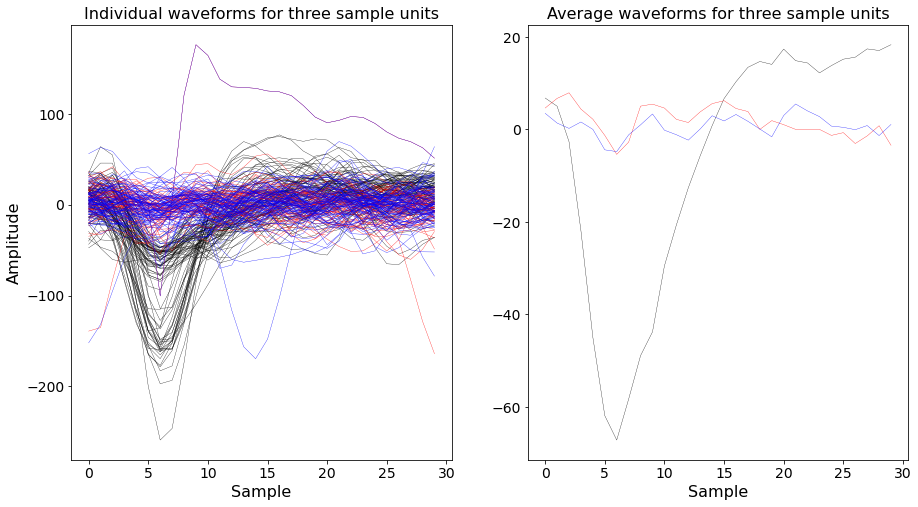

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(15,8))

ax[0].plot(waveforms[0][:, 0, :].T, color='k', lw=0.3)
ax[0].plot(waveforms[1][:, 0, :].T, color='r', lw=0.3)
ax[0].plot(waveforms[2][:, 0, :].T, color='b', lw=0.3)
ax[0].set_xlabel('Sample', fontsize=16)
ax[0].set_ylabel('Amplitude', fontsize=16)
ax[0].set_title('Individual waveforms for three sample units', fontsize=16)

ax[1].plot(avg_waveforms[0][0].T, color='k', lw=0.3)
ax[1].plot(avg_waveforms[1][0].T, color='r', lw=0.3)
ax[1].plot(avg_waveforms[2][0].T, color='b', lw=0.3)
ax[1].set_xlabel('Sample', fontsize=16)
ax[1].set_title('Average waveforms for three sample units', fontsize=16)

Similarly, we can get templates, maximum channels, and pca scores. 
When these are computed, they are automatically stored in the `SortingExtractor` object, so that they don't need to be recomputed. 

Each waveform is associated with a specific spike, so they are saved as spike *features*:


Note that we only selected a subset of waveforms above to speed up the computation, in truth there are a lot more spikes:

In [29]:
len(sorting_MS4.get_unit_spike_train(1))

/home/sbuergers/spikeinterface/hussaini_test_pipeline/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853:

76

The `waveform_idxs` property contains the spike indexes associated with the waveforms.

In [30]:
sorting_MS4.get_shared_unit_spike_feature_names()

['waveforms', 'waveforms_idxs']

In [31]:
print(sorting_MS4.get_unit_spike_features(1, 'waveforms_idxs'))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75]


Since waveforms are already computed, the next time we (or another function - e.g. `get_unit_templates()`) call it it will just return the stored waveforms.

In [32]:
waveforms = st.postprocessing.get_unit_waveforms(r_cache, sorting_MS4, verbose=True)

Lighthing fast! 

If we want to recompute the waveforms, for example because we want to extract the waveforms divided by group, we can use the `recompute_info` argument (available for all `postprocessing`, `validation`, and `curation` functions).

Where are waveforms stored? We have seen above that each `Extractor` object has an associated tmp folder. Waveforms (and other features, e.g. pca scores) are stored in this folder as binary files:

In [33]:
tmp_folder = sorting_MS4.get_tmp_folder()
print(tmp_folder)
print([(p.name) for p in tmp_folder.iterdir()])

/tmp/tmp9y8qgflq
['waveforms_92.raw', 'waveforms_153.raw', 'waveforms_56.raw', 'waveforms_36.raw', 'waveforms_25.raw', 'waveforms_33.raw', 'waveforms_71.raw', 'waveforms_78.raw', 'waveforms_18.raw', 'waveforms_123.raw', 'waveforms_53.raw', 'waveforms_178.raw', 'waveforms_52.raw', 'waveforms_145.raw', 'waveforms_64.raw', 'waveforms_47.raw', 'waveforms_111.raw', 'waveforms_135.raw', 'waveforms_181.raw', 'waveforms_27.raw', 'waveforms_57.raw', 'waveforms_62.raw', 'waveforms_109.raw', 'waveforms_96.raw', 'waveforms_142.raw', 'waveforms_48.raw', 'waveforms_17.raw', 'waveforms_133.raw', 'waveforms_61.raw', 'waveforms_16.raw', 'waveforms_166.raw', 'waveforms_94.raw', 'waveforms_46.raw', 'waveforms_42.raw', 'waveforms_74.raw', 'waveforms_152.raw', 'waveforms_121.raw', 'waveforms_158.raw', 'waveforms_113.raw', 'waveforms_91.raw', 'waveforms_185.raw', 'waveforms_90.raw', 'waveforms_72.raw', 'waveforms_6.raw', 'waveforms_8.raw', 'waveforms_164.raw', 'waveforms_112.raw', 'waveforms_50.raw', 'wavef

In [34]:
waveforms_group = st.postprocessing.get_unit_waveforms(
    r_cache,
    sorting_MS4,
    max_spikes_per_unit=None, 
    grouping_property='group',
    recompute_info=True,
    verbose=True
)

Number of chunks: 1 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##########| 1/1 [00:00<00:00,  1.24it/s]
/home/sbuergers/spikeinterface/spiketoolkit/spiketoolkit/postprocessing/postprocessing_tools.py:302: UserWarning: Grouping property not in sorting extractor. Computing it from the recording extractor
  warnings.warn('Grouping property not in sorting extractor. Computing it from the recording extractor')


In [35]:
sorting_MS4.get_shared_unit_property_names()

['template']

In [36]:
for wf in waveforms_group:
    print(wf.shape)

(76, 192, 180)
(45, 192, 180)
(71, 192, 180)
(24, 192, 180)
(65, 192, 180)
(49, 192, 180)
(50, 192, 180)
(18, 192, 180)
(47, 192, 180)
(54, 192, 180)
(27, 192, 180)
(21, 192, 180)
(42, 192, 180)
(46, 192, 180)
(27, 192, 180)
(25, 192, 180)
(39, 192, 180)
(47, 192, 180)
(32, 192, 180)
(20, 192, 180)
(44, 192, 180)
(22, 192, 180)
(31, 192, 180)
(27, 192, 180)
(48, 192, 180)
(32, 192, 180)
(46, 192, 180)
(38, 192, 180)
(55, 192, 180)
(56, 192, 180)
(46, 192, 180)
(78, 192, 180)
(43, 192, 180)
(44, 192, 180)
(47, 192, 180)
(35, 192, 180)
(30, 192, 180)
(48, 192, 180)
(74, 192, 180)
(41, 192, 180)
(36, 192, 180)
(67, 192, 180)
(14, 192, 180)
(16, 192, 180)
(44, 192, 180)
(101, 192, 180)
(22, 192, 180)
(20, 192, 180)
(53, 192, 180)
(37, 192, 180)
(36, 192, 180)
(51, 192, 180)
(34, 192, 180)
(46, 192, 180)
(38, 192, 180)
(43, 192, 180)
(17, 192, 180)
(71, 192, 180)
(108, 192, 180)
(50, 192, 180)
(31, 192, 180)
(58, 192, 180)
(84, 192, 180)
(46, 192, 180)
(38, 192, 180)
(28, 192, 180)
(15, 192

We can use `spikewidgets` to quickly inspect the spike sorting output:

In [37]:
dir_name

'/mnt/d/freelance-work/catalyst-neuro/hussaini-lab-to-nwb/Intan_data'

In [38]:
unit_ids = sorting_MS4.get_unit_ids()

/home/sbuergers/spikeinterface/hussaini_test_pipeline/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853:

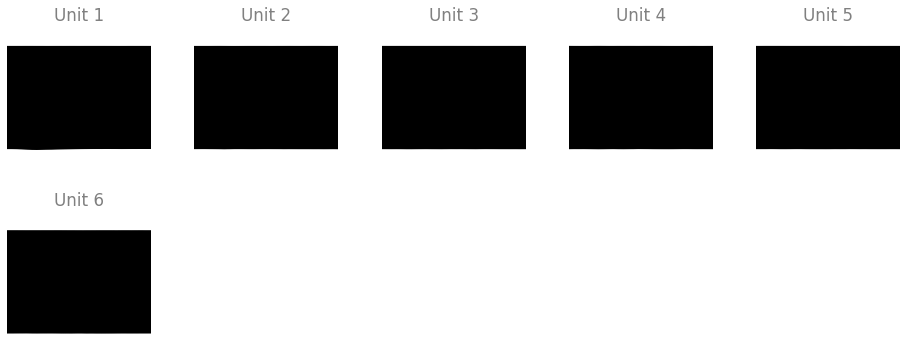

In [101]:
w_wf = sw.plot_unit_templates(sorting=sorting_MS4, recording=r_cache, unit_ids=unit_ids[0:6])

/home/sbuergers/spikeinterface/hussaini_test_pipeline/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853:

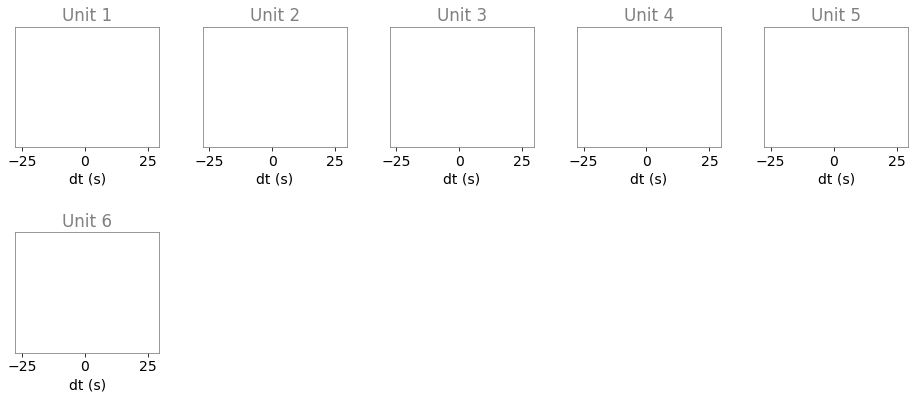

In [40]:
w_acc = sw.plot_autocorrelograms(sorting_MS4, unit_ids=unit_ids[0:6])

### Compute extracellular features
[back to index](#index)

Extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). The `postprocessing` module of `spiketoolkit` allows one to compute several of these features:

In [41]:
st.postprocessing.get_template_features_list()

/home/sbuergers/spikeinterface/hussaini_test_pipeline/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['peak_to_valley',
 'halfwidth',
 'peak_trough_ratio',
 'repolarization_slope',
 'recovery_slope']

In [42]:
features = st.postprocessing.compute_unit_template_features(
    r_cache, 
    sorting_MS4, 
    as_dataframe=True, 
    upsampling_factor=10
)
display(features)

/home/sbuergers/spikeinterface/hussaini_test_pipeline/venv/lib/python3.8/site-packages/spikefeatures/features.py:206: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return_to_base_idx = np.empty(waveforms.shape[0], dtype=np.int)


,peak_to_valley,halfwidth,peak_trough_ratio,repolarization_slope,recovery_slope
1,0.000763,0.000207,-0.300622,270241.277957,-480284.542571
2,0.000530,0.000130,-0.228837,142747.077669,-13841.817302
3,0.000523,0.000157,-0.256868,246277.112329,-14578.421662
4,0.000757,0.000270,-0.355271,98801.247921,-256279.662587
5,0.000493,0.000140,-0.222198,130067.659320,-6204.785124
...,...,...,...,...,...
188,0.000663,0.000130,-0.226539,122163.840440,-39980.423071
189,0.000763,0.000133,-0.161922,22256.668245,-110378.449139
190,0.000643,0.000137,-0.121986,55878.505217,-14811.390494
191,0.000640,0.000140,-0.201404,78051.486164,-6666.459166


For more information about these waveform features, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

### Validation
[back to index](#index)

The `spiketoolkit` package also provides several functions to compute qualitity metrics about the spike sorting results through the `validation` module.

Let's see what metrics are available:

In [43]:
st.validation.get_quality_metrics_list()

/home/sbuergers/spikeinterface/hussaini_test_pipeline/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['num_spikes',
 'firing_rate',
 'presence_ratio',
 'isi_violation',
 'amplitude_cutoff',
 'snr',
 'max_drift',
 'cumulative_drift',
 'silhouette_score',
 'isolation_distance',
 'l_ratio',
 'd_prime',
 'noise_overlap',
 'nn_hit_rate',
 'nn_miss_rate']

We can compute a subset of quality metrics using the `compute_quality_metrics` function. 


In [44]:
quality_metrics = st.validation.compute_quality_metrics(
    sorting_MS4, 
    r_cache, 
    metric_names=['firing_rate', 'isi_violation', 'snr'], 
    as_dataframe=True
)
display(quality_metrics)

/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, 

,firing_rate,isi_violation,snr
1,76.0,0.291792,5.018699
2,45.0,0.665834,3.018545
3,71.0,0.668674,3.440160
4,24.0,0.000000,2.911047
5,65.0,0.239346,3.842335
...,...,...,...
188,27.0,0.000000,3.060556
189,35.0,1.100665,2.947468
190,28.0,0.000000,2.940668
191,41.0,0.000000,2.866216


Select units with few isi violations.

In [45]:
unit_ids_of_interest = quality_metrics.loc[quality_metrics['isi_violation'] < 10,:].index.values

/home/sbuergers/spikeinterface/hussaini_test_pipeline/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/sbuergers/spikeinterface/hussaini_test_pipeline/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


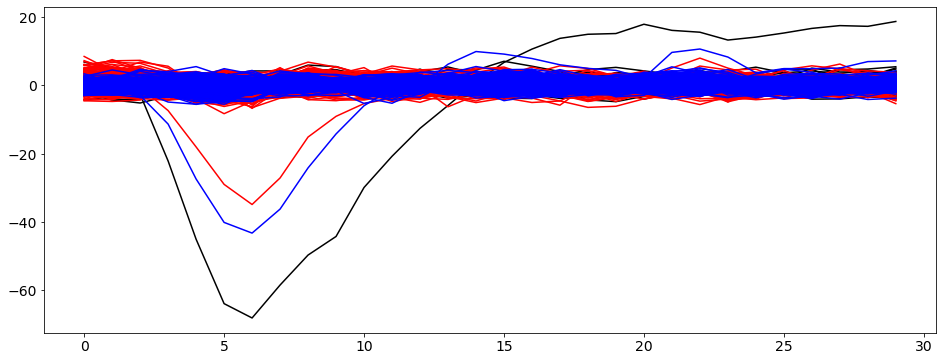

In [46]:
templates = st.postprocessing.get_unit_templates(
    r_cache, sorting_MS4, max_spikes_per_unit=200,
    unit_ids=unit_ids_of_interest,
    save_as_property=True, verbose=True
)

fig, ax = plt.subplots()
ax.plot(templates[0].T, color='k')
ax.plot(templates[1].T, color='r')
ax.plot(templates[2].T, color='b')

<a id="spike_curation"></a>
# 7. Curation
[back to index](#index)

### 1) Manual curation using Phy

To perform manual curation we will export the data to [Phy](https://github.com/cortex-lab/phy). 

In [47]:
st.postprocessing.export_to_phy(
    r_cache, 
    sorting_MS4, 
    output_folder='phy_MS4',
    grouping_property='group', 
    verbose=True, 
    recompute_info=True
)

/home/sbuergers/spikeinterface/hussaini_test_pipeline/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853:

Converting to Phy format
Disabling 'max_channels_per_template'. Channels are extracted using 'grouping_property'
Number of chunks: 1 - Number of jobs: 1


Extracting waveforms in chunks: 100%|##########| 1/1 [00:00<00:00,  1.22it/s]


Fitting PCA of 3 dimensions on 7195 waveforms
Projecting waveforms on PC


/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:847: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(start_frame, (float, np.float)):
/home/sbuergers/spikeinterface/spikeextractors/spikeextractors/extraction_tools.py:853: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if isinstance(end_frame, 

Saving files
Saved phy format to:  /home/sbuergers/spikeinterface/hussaini-lab-to-nwb/hussaini_lab_to_nwb/tutorials/phy_MS4
Run:

phy template-gui  /home/sbuergers/spikeinterface/hussaini-lab-to-nwb/hussaini_lab_to_nwb/tutorials/phy_MS4/params.py


If you have trouble using the GUI from phy have a look at the instructions here: https://github.com/cortex-lab/phy.

In [48]:
!phy template-gui phy_MS4/params.py

/home/sbuergers/spikeinterface/hussaini_test_pipeline/venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-sbuergers'
14:51:33.216 [I] supervisor:710       Change metadata_group for clusters 0 to noise.
14:51:34.639 [I] supervisor:710       Change metadata_group for clusters 1 to noise.
14:51:36.036 [I] supervisor:710       Change metadata_group for clusters 2 to noise.
14:51:36.778 [I] supervisor:710       Change metadata_group for clusters 3 to noise.
14:51:37.425 [I] supervisor:710       Change metadata_group for clusters 4 to noise.
14:51:38.058 [I] supervisor:710       Change metadata_group for clusters 5 to noise.
14:51:38.707 [I] supervisor:710       Change metadata_group for clusters 6 to noise.
14:51:39.505 [I] supervisor:710       Change metadata_group for clusters 7 to noise.
14:51:40.194 [I] supervisor:710       Change metadata_group for clusters 8 to noise.
14:51:41.119 [I] supervisor:710       Change metadata_group for clusters 9 to noise.
14:51:41.913 [I] supervisor:710       Change metadata_group for cluste

14:52:55.162 [I] supervisor:710       Change metadata_group for clusters 87 to noise.
14:52:56.079 [I] supervisor:710       Change metadata_group for clusters 88 to noise.
14:52:56.093 [I] supervisor:710       Change metadata_group for clusters 88 to noise.
14:52:57.956 [I] supervisor:710       Change metadata_group for clusters 90 to noise.
14:52:58.013 [I] supervisor:710       Change metadata_group for clusters 91 to noise.
14:52:58.083 [I] supervisor:710       Change metadata_group for clusters 92 to noise.
14:52:59.152 [I] supervisor:710       Change metadata_group for clusters 93 to noise.
14:52:59.752 [I] supervisor:710       Change metadata_group for clusters 94 to noise.
14:53:02.335 [I] supervisor:710       Change metadata_group for clusters 95 to noise.
14:53:02.588 [I] supervisor:710       Change metadata_group for clusters 96 to noise.
14:53:07.090 [I] supervisor:710       Change metadata_group for clusters 89 to noise.
14:53:09.865 [I] supervisor:710       Change metadata_

After curating the results we can reload it using the PhySortingExtractor:

In [ ]:
sorting_MS4_phy_curated = se.PhySortingExtractor('phy_MS4/', exclude_cluster_groups=['noise'])

In [ ]:
print(len(sorting_MS4_phy_curated.get_unit_ids()))
print(f"Unit ids after manual curation: {sorting_MS4_phy_curated.get_unit_ids()}")

In [ ]:
_ = [print(sorting_MS4_phy_curated.get_unit_property(i, 'quality')) for i in sorting_MS4_phy_curated.get_unit_ids()]

### b) Automatic curation based on quality metrics
[back to index](#index)

We will demonstrate here how to select subsets of candidate units based on the quality metrics inter-spike interval (isi) and signal to noise ratio (snr).

In [ ]:
st.curation.threshold_isi_violations?

In [ ]:
snr_thresh = 4
isi_viol_thresh = 0.0015
duration = r_cache.get_num_frames()

In [ ]:
isi_violations = st.validation.compute_isi_violations(
    sorting_MS4, 
    duration_in_frames=r_cache.get_num_frames(), 
    isi_threshold=0.0015
)

In [ ]:
isi_violations

In [ ]:
sorting_auto_MS4 = st.curation.threshold_isi_violations(sorting_MS4, isi_viol_thresh, 'greater', duration)
sorting_auto_SC = st.curation.threshold_isi_violations(sorting_SC, isi_viol_thresh, 'greater', duration)

In [ ]:
print('Number of units Mountainsort4: {}'.format(len(sorting_auto_MS4.get_unit_ids())))
print('Number of units Spyking Circus: {}'.format(len(sorting_auto_SC.get_unit_ids())))

In [ ]:
sorting_auto_MS4 = st.curation.threshold_snrs(sorting_auto_MS4, r_cache, snr_thresh, 'less')
sorting_auto_SC = st.curation.threshold_snrs(sorting_auto_SC, r_cache, snr_thresh, 'less')

In [ ]:
print('Number of units Mountainsort4: {}'.format(len(sorting_auto_MS4.get_unit_ids())))
print('Number of units Spyking Circus: {}'.format(len(sorting_auto_SC.get_unit_ids())))

### c) Consensus-based curation
[back to index](#index)

Can we combine the output of multiple sorters to curate the spike sorting output?

Yes, with the `spikecomparison` module we can compare and match the output spike trains of the different sorters, and retrieve a new sorting extractor object containing only the units that were in agreement.

In [ ]:
mcmp = sc.compare_multiple_sorters(
    [sorting_auto_SC, sorting_auto_MS4], 
    ['SC', 'MS4'], 
    spiketrain_mode='union',
    verbose=True
)

In [ ]:
w = sw.plot_multicomp_agreement(mcmp)
w = sw.plot_multicomp_agreement_by_sorter(mcmp)

In [ ]:
agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=2)

In [ ]:
agreement_sorting.get_unit_ids()

In [ ]:
cmp_manual_agr = sc.compare_sorter_to_ground_truth(sorting_MS4_phy_curated, agreement_sorting)

In [ ]:
w_agr = sw.plot_agreement_matrix(cmp_manual_agr)

In [ ]:
w_wf = sw.plot_unit_templates(sorting=agreement_sorting, recording=r_cache, unit_ids=[1])

In [ ]:
st.postprocessing.export_to_phy(
    r_cache, 
    agreement_sorting, 
    output_folder='phy_AGR',
    grouping_property='group', 
    verbose=True, 
    recompute_info=True
)

<a id="export_nwb"></a>
# 8. Save to / load from NWB
[back to index](#index)

In this section we briefly go through the process of exporting recording extractor and sorting extractor objects to the `nwb` file format. We will use the `spikeextractors` classes `NwbRecordingExtractor` and `NwbSortingExtractor`. It can be useful to pass metadata to the `nwb` file during export (i.e. data that describes the ecephys data in this case) and we illustrate this here by passing information about the recording device.

In [ ]:
from pynwb import NWBFile, NWBHDF5IO
from pathlib import Path

In [ ]:
metadata = {'Ecephys': {'Device': [{'name': 'Axona',
                                    'description': 'Axona DacqUSB acquisition system'}]}}

In [ ]:
nwb_dir = Path(dir_name, 'nwb')

nwb_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
se.NwbRecordingExtractor.write_recording(r_cache, nwb_dir / 'axona_re.nwb', metadata=metadata)

In [ ]:
se.NwbSortingExtractor.write_sorting(sorting_MS4_phy_curated, nwb_dir / 'axona_se_MS4_man_curation.nwb')

(Re-)load data into recording and sorting extractor.

In [ ]:
recording_nwb = se.NwbRecordingExtractor(nwb_dir / 'axona_re.nwb')

In [ ]:
sorting_nwb = se.NwbSortingExtractor(nwb_dir / 'axona_se_MS4_man_curation.nwb', sampling_frequency=48000)

---
I hope this notebook was helpful to you. If you have any suggestions, questions or concerns do not hesitate to contact me at `steffen.burgers@catalystneuro.com`.